<font size=8> Network Tests


In [46]:
#Common Python Packages
from pickle import TRUE
import pickle
import numpy as np
import matplotlib.pyplot as plt
import timeout_decorator

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from itertools import product
#my imports
from adaptation import pc_single,ff,pc_pv_sst,ff_network
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from configs import neuron_configs_bio


# Determine the user's home directory
home_directory = os.path.expanduser("~")
# Path to the Documents directory
documents_path = os.path.join(home_directory, "Documents")
# Path to the dynapse-se2-data directory within Documents
save_directory_path = os.path.join(documents_path, "dynapse-se2-data")
# Path to the data
data_type_path = os.path.join(save_directory_path, "network")

@timeout_decorator.timeout(40)  # Set a 5-second timeout
def run_simulation(neuron_config):
    return pc_pv_sst.pc_pv_sst(
        board=board,
        profile_path=profile_path,
        number_of_chips=number_of_chips,
        neuron_config=neuron_config
    )

In [85]:
[board,profile_path,number_of_chips]=obtain_board()

[]


IndexError: list index out of range

<font size=7> Manual Tuning


In [109]:
neuron_config=neuron_configs_bio.config()

neuron_config['PC_W3']=[5,100]#input weight to PC
neuron_config['PV_W3']=[5,100]#input weight to PV
neuron_config['PV_W0']=[2,100]#input weight to PV

neuron_config['PV_W3']=[5,100]#input weight to PV

neuron_config['SST_W0']=[0,30]#input weight to SST
neuron_config['SST_W1']=[0,20]#input weight to SST

neuron_config['SST_AMPA_GAIN']=[3,120]
neuron_config['SST_LEAK']=[0,15]
neuron_config['SST_AMPA_TAU']=[0,15]

neuron_config['Input_SST']=.05#.1#.1
neuron_config['PC_SST']=.01#.1
neuron_config['SST_PV']=.4#.1
neuron_config['SST_PC']=.4#.1


neuron_config['PC_Adaptation']=True
neuron_config['duration']=1.5
neuron_config['input_type']='Regular'
neuron_config['in_freq']=30

[output_events,test_config]=pc_pv_sst.pc_pv_sst(board=board, profile_path=profile_path, number_of_chips=number_of_chips,neuron_config=neuron_config)
[cv_values,synchrony_values]=run_dynamic_anal(output_events,test_config)
if 'raster_fig' in locals() and raster_fig is not None:
    raster_fig.savefig('raster_previous.png')
if 'fvt_fig' in locals() and fvt_fig is not None:
    fvt_fig.savefig('fvt_previous.png')
raster_fig=script_annotated_raster_plot(test_config,output_events,neuron_config,cv_values=cv_values,syn_values=synchrony_values,save=True,annotate=False,annotate_network=True)
fvt_fig=frequency_vs_time_plot(frequency_over_time(test_config,output_events),test_config,save=True,annotate=False)
raster_fig.savefig('raster_current.png')
fvt_fig.savefig('fvt_current.png')

Setting Latches
Setting up network
Adding connections

Setting monitors
20 100 10

All configurations done!

Input events created
initilize run dynapse
dummy events sent

getting fpga time



In [102]:
output_events=np.asanyarray(output_events)
times=output_events[1]-output_events[1][0]
spike_id=output_events[0]
neuron_n=100
virual_n=15
pc_id, pc_times = get_id_times(virual_n, neuron_n, spike_id, times)
bin_size=0.020


if virual_n > 0:
    input_id = spike_id[spike_id <= virual_n]
    input_time = times[spike_id <= virual_n]

[isi_list,isi_times]=extract_isi(pc_id,pc_times)
# PSTH plot
spike_times = spike_time_arrays(output_events, virual_n, neuron_n)[2]
psth, bins = psth_calc(spike_times, bin_size, duration=1)
# Flatten the ISI lists
all_isis = np.concatenate(isi_list)
    
duration = 1   


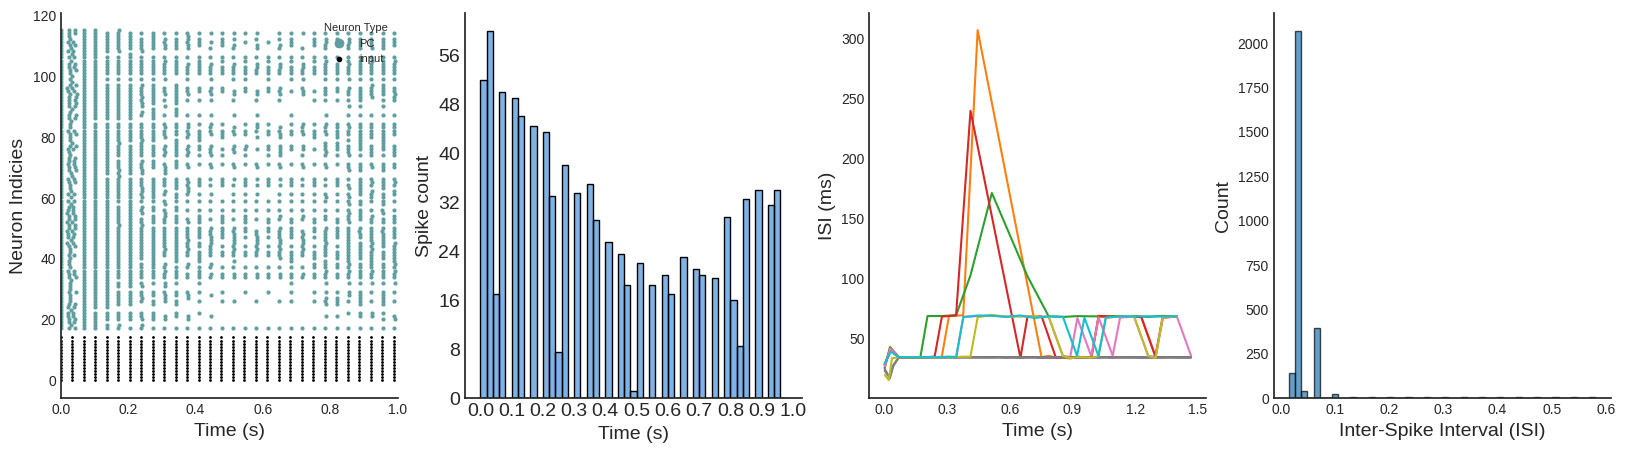

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Control variable for fontsize
FONT_SIZE = 14

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
ax1, ax2, ax3, ax4 = axs

# Raster plot
ax1.scatter(pc_times, pc_id, c='cadetblue', s=4, label='PC')
ax1.scatter(input_time, input_id, c='k', s=1, label='input')
ax1.set_ylabel('Neuron Indicies', fontsize=FONT_SIZE)
ax1.set_xlabel('Time (s)', fontsize=FONT_SIZE)
ax1.legend(loc="upper right", title='Neuron Type', numpoints=1, fontsize=8, markerscale=3, title_fontsize=8)
ax1.set_xlim(0, duration)
ax1.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6)) # Reduce number of x-ticks

# PSTH plot
bar_color = (0, 0.4, 0.8, 0.5)
ax2.bar(bins[:-1], psth, width=bin_size, align='edge', color=bar_color, edgecolor='black', linewidth=1)
ax2.set_xlabel('Time (s)', fontsize=FONT_SIZE)
ax2.set_ylabel('Spike count', fontsize=FONT_SIZE)
ax2.set_xticks(np.arange(0, duration, 0.1))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(.1))
ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax2.tick_params(axis='both', which='major', labelsize=FONT_SIZE)

# ISI times plot
for i in np.arange(20,30):
    ax3.plot(isi_times[i], isi_list[i]*1000,label='neuron id: '+str(i))
ax3.set_xlabel('Time (s)', fontsize=FONT_SIZE)
ax3.set_ylabel('ISI (ms)', fontsize=FONT_SIZE)
ax3.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6)) # Reduce number of x-ticks

# ISI histogram
ax4.hist(all_isis, bins=50, edgecolor='black', alpha=0.7)
ax4.set_xlabel('Inter-Spike Interval (ISI)', fontsize=FONT_SIZE)
ax4.set_ylabel('Count', fontsize=FONT_SIZE)

# Remove top and right spines for all subplots
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
plt.show()


In [12]:
# Save the updated data
if not os.path.exists(data_type_path):
    os.makedirs(data_type_path)
np.save(os.path.join(data_type_path, "EI_0_PCPC_Poisson.npy"), output_events)

<font size=8> Regular


In [42]:
neuron_config=neuron_configs_bio.config()

neuron_config['SST_W0']=[0,0]#input weight to SST
neuron_config['SST_W1']=[0,0]#PC to SST weight
neuron_config['SST_W2']=[0,00]#PV shunt inhibition to SST

neuron_config['SST_AMPA_GAIN']=[0,200]
neuron_config['SST_AMPA_TAU']=[2,10]
neuron_config['SST_LEAK']=[0,80]#

neuron_config['Input_SST']=.0#.1#.1

neuron_config['PC_SST']=.2#.1
neuron_config['PC_PC']=.2#.1

neuron_config['PC_Adaptation']=True
neuron_config['duration']=1
neuron_config['input_type']='Regular'
neuron_config['in_freq']=20

[output_events,test_config]=pc_pv_sst.pc_pv_sst(board=board, profile_path=profile_path, number_of_chips=number_of_chips,neuron_config=neuron_config)
[cv_values,synchrony_values]=run_dynamic_anal(output_events,test_config)
if 'raster_fig' in locals() and raster_fig is not None:
    raster_fig.savefig('raster_previous.png')
if 'fvt_fig' in locals() and fvt_fig is not None:
    fvt_fig.savefig('fvt_previous.png')
raster_fig=script_annotated_raster_plot(test_config,output_events,neuron_config,cv_values=cv_values,syn_values=synchrony_values,save=True,annotate=False,annotate_network=True)
fvt_fig=frequency_vs_time_plot(frequency_over_time(test_config,output_events),test_config,save=True,annotate=False)
raster_fig.savefig('raster_current.png')
fvt_fig.savefig('fvt_current.png')


Setting Latches
Setting up network
Adding connections

Setting monitors
20 100 10

All configurations done!

Input events created
initilize run dynapse
dummy events sent

getting fpga time


setting virtual neurons

Simulation done
PC_CV_average: 0.07 PV_CV_average: 0.36 SST_CV_average: 0.0
PC_synchrony: 0.23 PV_CV_average: 0.47 SST_CV_average: nan


In [45]:
# Save the updated data
if not os.path.exists(data_type_path):
    os.makedirs(data_type_path)
np.save(os.path.join(data_type_path, "EI_2_PCPC_regular.npy"), output_events)

In [46]:
output_events=np.asanyarray(output_events)
times=output_events[1]-output_events[1][0]
spike_id=output_events[0]
neuron_n=100
virual_n=15
pc_id, pc_times = get_id_times(virual_n, neuron_n, spike_id, times)
bin_size=0.020


if virual_n > 0:
    input_id = spike_id[spike_id <= virual_n]
    input_time = times[spike_id <= virual_n]

[isi_list,isi_times]=extract_isi(pc_id,pc_times)
# PSTH plot
spike_times = spike_time_arrays(output_events, virual_n, neuron_n)[2]
psth, bins = psth_calc(spike_times, bin_size, duration=1)
# Flatten the ISI lists
all_isis = np.concatenate(isi_list)
    
duration = 1   

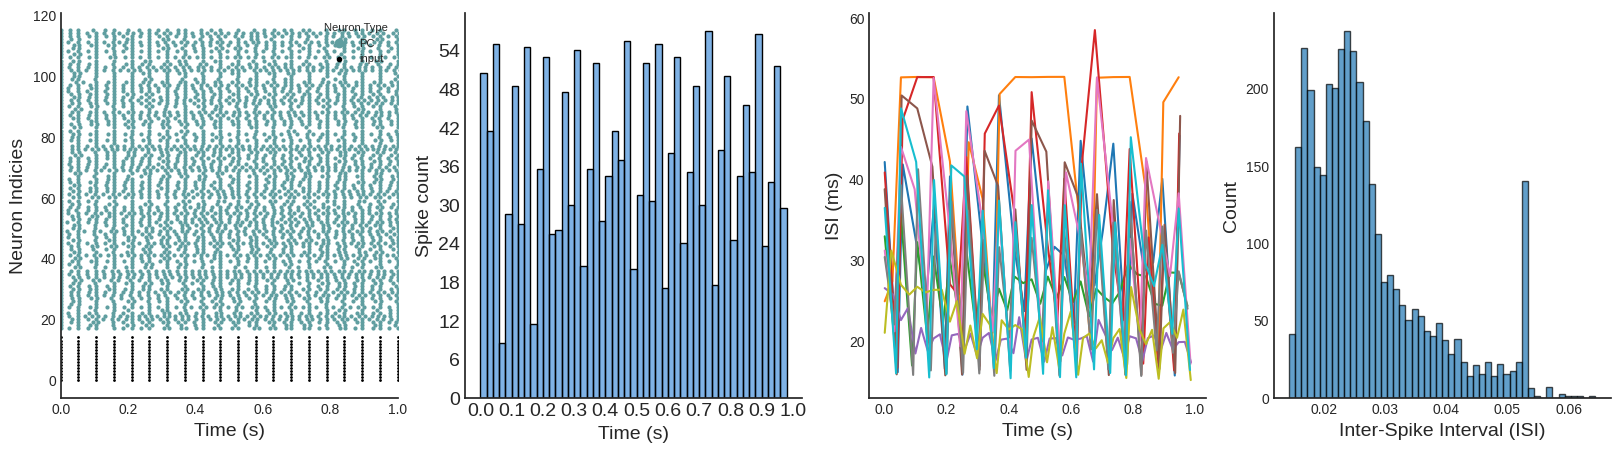

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Control variable for fontsize
FONT_SIZE = 14

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
ax1, ax2, ax3, ax4 = axs

# Raster plot
ax1.scatter(pc_times, pc_id, c='cadetblue', s=4, label='PC')
ax1.scatter(input_time, input_id, c='k', s=1, label='input')
ax1.set_ylabel('Neuron Indicies', fontsize=FONT_SIZE)
ax1.set_xlabel('Time (s)', fontsize=FONT_SIZE)
ax1.legend(loc="upper right", title='Neuron Type', numpoints=1, fontsize=8, markerscale=3, title_fontsize=8)
ax1.set_xlim(0, duration)
ax1.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6)) # Reduce number of x-ticks

# PSTH plot
bar_color = (0, 0.4, 0.8, 0.5)
ax2.bar(bins[:-1], psth, width=bin_size, align='edge', color=bar_color, edgecolor='black', linewidth=1)
ax2.set_xlabel('Time (s)', fontsize=FONT_SIZE)
ax2.set_ylabel('Spike count', fontsize=FONT_SIZE)
ax2.set_xticks(np.arange(0, duration, 0.1))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(.1))
ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax2.tick_params(axis='both', which='major', labelsize=FONT_SIZE)

# ISI times plot
for i in np.arange(20,30):
    ax3.plot(isi_times[i], isi_list[i]*1000,label='neuron id: '+str(i))
ax3.set_xlabel('Time (s)', fontsize=FONT_SIZE)
ax3.set_ylabel('ISI (ms)', fontsize=FONT_SIZE)
ax3.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6)) # Reduce number of x-ticks

# ISI histogram
ax4.hist(all_isis, bins=50, edgecolor='black', alpha=0.7)
ax4.set_xlabel('Inter-Spike Interval (ISI)', fontsize=FONT_SIZE)
ax4.set_ylabel('Count', fontsize=FONT_SIZE)

# Remove top and right spines for all subplots
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
plt.show()


In [3]:
neuron_config=neuron_configs_bio.config()

neuron_config['SST_W0']=[0,0]#input weight to SST
neuron_config['SST_W1']=[0,0]#PC to SST weight
neuron_config['SST_W2']=[0,00]#PV shunt inhibition to SST

neuron_config['SST_AMPA_GAIN']=[0,200]
neuron_config['SST_AMPA_TAU']=[2,10]
neuron_config['SST_LEAK']=[0,80]#

neuron_config['Input_SST']=.0#.1#.1

neuron_config['PC_SST']=.2#.1
neuron_config['PC_PC']=0#.1

neuron_config['PC_Adaptation']=True
neuron_config['duration']=1
neuron_config['input_type']='Regular'
neuron_config['in_freq']=20

[output_events,test_config]=pc_pv_sst.pc_pv_sst(board=board, profile_path=profile_path, number_of_chips=number_of_chips,neuron_config=neuron_config)
[cv_values,synchrony_values]=run_dynamic_anal(output_events,test_config)
if 'raster_fig' in locals() and raster_fig is not None:
    raster_fig.savefig('raster_previous.png')
if 'fvt_fig' in locals() and fvt_fig is not None:
    fvt_fig.savefig('fvt_previous.png')
raster_fig=script_annotated_raster_plot(test_config,output_events,neuron_config,cv_values=cv_values,syn_values=synchrony_values,save=True,annotate=False,annotate_network=True)
fvt_fig=frequency_vs_time_plot(frequency_over_time(test_config,output_events),test_config,save=True,annotate=False)
raster_fig.savefig('raster_current.png')
fvt_fig.savefig('fvt_current.png')


Setting Latches
Setting up network
Adding connections

Setting monitors
20 100 10

All configurations done!

Input events created
initilize run dynapse
dummy events sent

getting fpga time


setting virtual neurons

Simulation done
PC_CV_average: 0.0 PV_CV_average: 0.17 SST_CV_average: 0.0
PC_synchrony: 0.99 PV_CV_average: 0.83 SST_CV_average: nan


In [4]:
output_events=np.asanyarray(output_events)
times=output_events[1]-output_events[1][0]
spike_id=output_events[0]
neuron_n=100
virual_n=15
pc_id, pc_times = get_id_times(virual_n, neuron_n, spike_id, times)
bin_size=0.020


if virual_n > 0:
    input_id = spike_id[spike_id <= virual_n]
    input_time = times[spike_id <= virual_n]

[isi_list,isi_times]=extract_isi(pc_id,pc_times)
# PSTH plot
spike_times = spike_time_arrays(output_events, virual_n, neuron_n)[2]
psth, bins = psth_calc(spike_times, bin_size, duration=1)
# Flatten the ISI lists
all_isis = np.concatenate(isi_list)
    
duration = 1   

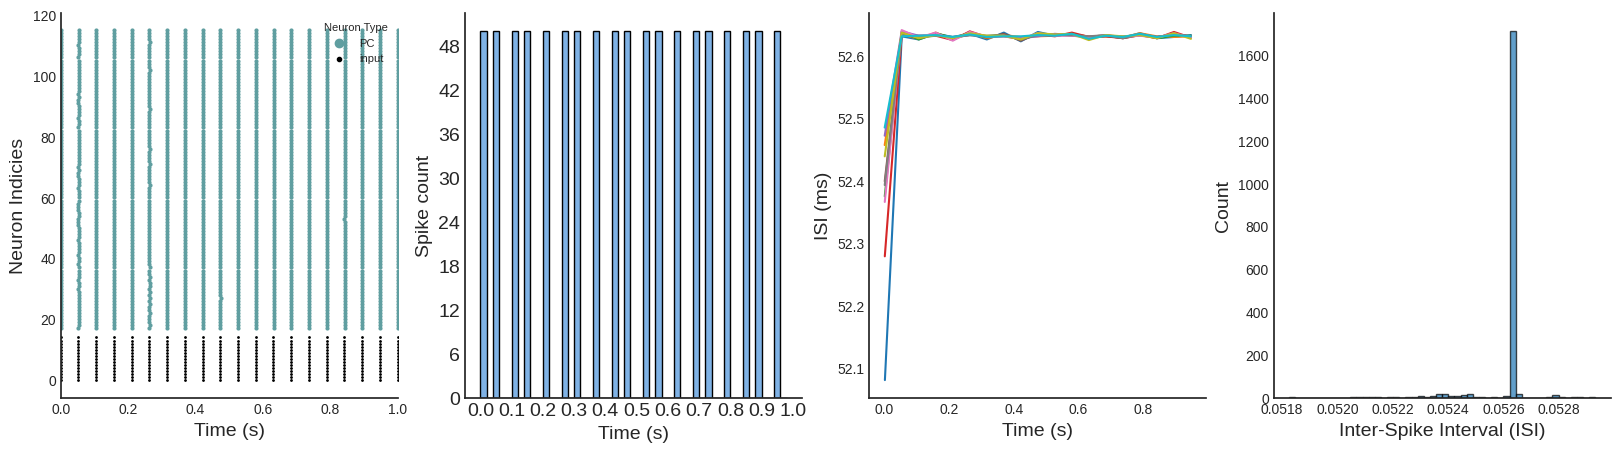

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Control variable for fontsize
FONT_SIZE = 14

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
ax1, ax2, ax3, ax4 = axs

# Raster plot
ax1.scatter(pc_times, pc_id, c='cadetblue', s=4, label='PC')
ax1.scatter(input_time, input_id, c='k', s=1, label='input')
ax1.set_ylabel('Neuron Indicies', fontsize=FONT_SIZE)
ax1.set_xlabel('Time (s)', fontsize=FONT_SIZE)
ax1.legend(loc="upper right", title='Neuron Type', numpoints=1, fontsize=8, markerscale=3, title_fontsize=8)
ax1.set_xlim(0, duration)
ax1.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6)) # Reduce number of x-ticks

# PSTH plot
bar_color = (0, 0.4, 0.8, 0.5)
ax2.bar(bins[:-1], psth, width=bin_size, align='edge', color=bar_color, edgecolor='black', linewidth=1)
ax2.set_xlabel('Time (s)', fontsize=FONT_SIZE)
ax2.set_ylabel('Spike count', fontsize=FONT_SIZE)
ax2.set_xticks(np.arange(0, duration, 0.1))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(.1))
ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax2.tick_params(axis='both', which='major', labelsize=FONT_SIZE)

# ISI times plot
for i in np.arange(20,30):
    ax3.plot(isi_times[i], isi_list[i]*1000,label='neuron id: '+str(i))
ax3.set_xlabel('Time (s)', fontsize=FONT_SIZE)
ax3.set_ylabel('ISI (ms)', fontsize=FONT_SIZE)
ax3.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6)) # Reduce number of x-ticks

# ISI histogram
ax4.hist(all_isis, bins=50, edgecolor='black', alpha=0.7)
ax4.set_xlabel('Inter-Spike Interval (ISI)', fontsize=FONT_SIZE)
ax4.set_ylabel('Count', fontsize=FONT_SIZE)

# Remove top and right spines for all subplots
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
plt.show()


In [5]:
# Save the updated data
if not os.path.exists(data_type_path):
    os.makedirs(data_type_path)
np.save(os.path.join(data_type_path, "EI_0_PCPC_regular.npy"), output_events)